In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-8 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 4000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

200000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

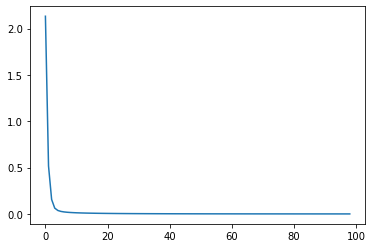

In [8]:
plt.plot(S)

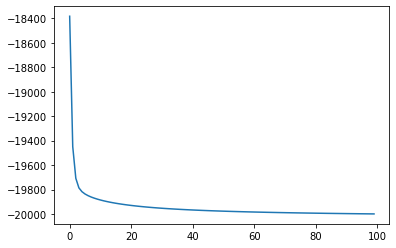

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0005335918516575475

In [11]:
eta

array([-18382.30627884, -19449.11327981, -19708.06000285, -19786.12159624,
       -19817.6155052 , -19836.48768194, -19850.23896823, -19861.2305996 ,
       -19870.46873911, -19878.47233925, -19885.54558216, -19891.88382758,
       -19897.62141086, -19902.85568457, -19907.6601639 , -19912.09220875,
       -19916.19776501, -19920.01442793, -19923.5735004 , -19926.90142345,
       -19930.02080027, -19932.95114854, -19935.70946589, -19938.31066363,
       -19940.76790545, -19943.09287611, -19945.29599774, -19947.38660597,
       -19949.37309515, -19951.26303913, -19953.06329276, -19954.78007768,
       -19956.41905552, -19957.98539067, -19959.48380443, -19960.91862195,
       -19962.29381321, -19963.61302879, -19964.87963136, -19966.09672341,
       -19967.26717186, -19968.39362976, -19969.47855577, -19970.52423142,
       -19971.53277661, -19972.5061635 , -19973.44622897, -19974.35468589,
       -19975.23313322, -19976.08306522, -19976.90587973, -19977.7028857 ,
       -19978.47531004, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([1.61709372e+03, 5.50286720e+02, 2.91339997e+02, 2.13278403e+02,
       1.81784494e+02, 1.62912318e+02, 1.49161031e+02, 1.38169400e+02,
       1.28931260e+02, 1.20927660e+02, 1.13854417e+02, 1.07516172e+02,
       1.01778589e+02, 9.65443150e+01, 9.17398357e+01, 8.73077908e+01,
       8.32022346e+01, 7.93855716e+01, 7.58264992e+01, 7.24985761e+01,
       6.93791993e+01, 6.64488510e+01, 6.36905337e+01, 6.10893359e+01,
       5.86320941e+01, 5.63071235e+01, 5.41040018e+01, 5.20133936e+01,
       5.00269044e+01, 4.81369604e+01, 4.63367068e+01, 4.46199219e+01,
       4.29809441e+01, 4.14146089e+01, 3.99161952e+01, 3.84813776e+01,
       3.71061864e+01, 3.57869708e+01, 3.45203682e+01, 3.33032762e+01,
       3.21328277e+01, 3.10063698e+01, 2.99214438e+01, 2.88757682e+01,
       2.78672230e+01, 2.68938361e+01, 2.59537706e+01, 2.50453137e+01,
       2.41668664e+01, 2.33169344e+01, 2.24941198e+01, 2.16971139e+01,
       2.09246895e+01, 2.01756958e+01, 1.94490516e+01, 1.87437410e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_1.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_1.csv', alpha, delimiter = ',')